# Patterns Behind Purchases: Analyzing Global E-Commerce

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

### 0) Setup Data

In [4]:
df = pd.read_csv("global_ecommerce_sales.csv")
display(df)

df["Order_Date"] = pd.to_datetime(df["Order_Date"], format="%m/%d/%Y", errors="coerce")
df = df.dropna(subset=["Order_Date"])

df["order_month"] = df["Order_Date"].dt.to_period("M").dt.to_timestamp()


,Order_ID,Country,Category,Unit_Price,Quantity,Order_Date,Total_Amount
0,1,Germany,Electronics,285.82,7,6/12/2025,2000.74
1,2,Pakistan,Toys,132.00,9,1/14/2025,1188.00
2,3,Australia,Fashion,481.65,9,8/27/2025,4334.85
3,4,UAE,Grocery,244.36,3,3/13/2025,733.08
4,5,Germany,Sports,403.97,5,5/23/2025,2019.85
...,...,...,...,...,...,...,...
1195,1196,China,Sports,274.52,6,6/3/2025,1647.12
1196,1197,Canada,Sports,481.57,1,2/4/2025,481.57
1197,1198,UK,Sports,42.42,6,3/20/2025,254.52
1198,1199,USA,Books,186.01,1,3/8/2025,186.01


### 1) Monthly Revenue Trend

,order_month,Total_Amount
0,2025-01-01,162944.58
1,2025-02-01,127450.66
2,2025-03-01,141141.78
3,2025-04-01,158166.28
4,2025-05-01,160141.26
5,2025-06-01,138792.41
6,2025-07-01,180208.16
7,2025-08-01,137276.89
8,2025-09-01,135177.50
9,2025-10-01,158668.22


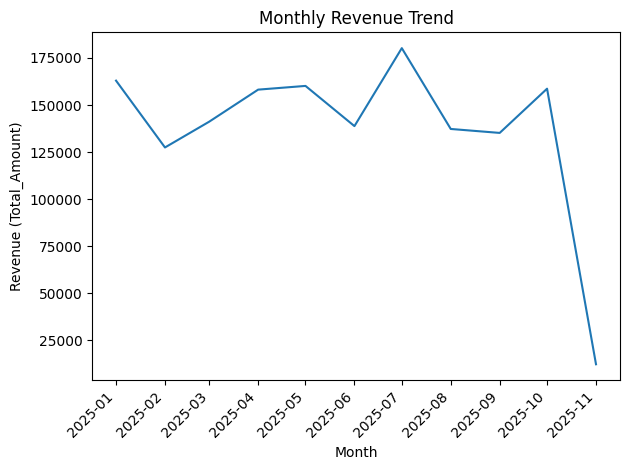

In [5]:
# Monthly Revenue Trend

monthly_rev = (
    df.groupby("order_month", as_index = False)["Total_Amount"]
      .sum()
      .sort_values("order_month")
)
display(monthly_rev)

plt.figure()
plt.plot(monthly_rev["order_month"], monthly_rev["Total_Amount"])
plt.xticks(rotation=45, ha="right")
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue (Total_Amount)")
plt.tight_layout()
plt.show()

- From January to October, revenue fluctuates within a relatively tight band (~130k-180k).
- There is no sustained upward or downward trend, which is suggesting the demand is stable.
- Revenue appears to be seasonal driven, not structurally growing.
- The sharp drop in November is not consistent with the rest of the pattern, which certainly indicates data extraction cutoff.

### 2) Revenue by Country (TOP 10)

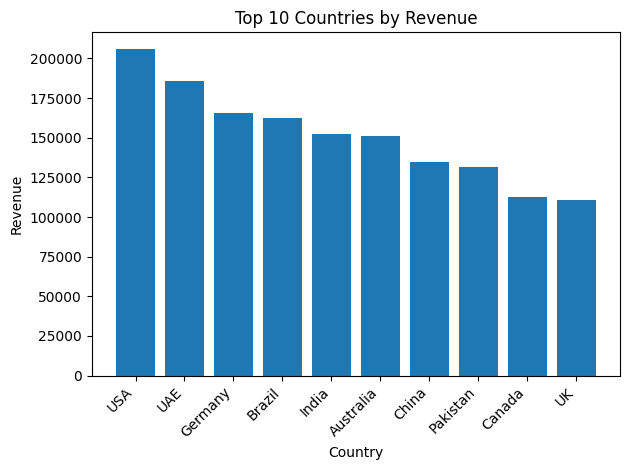

In [6]:
country_rev = (
    df.groupby("Country", as_index = False)["Total_Amount"]
    .sum()
    .sort_values("Total_Amount", ascending = False)
)
top10_country = country_rev.head(10)

plt.figure()
plt.bar(top10_country["Country"], top10_country["Total_Amount"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Country")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show();

- USA is the largest revenue contributor by a clear margin.
- There's a noticeable drop from the USA to the next tier of countries with the minimum difference of 125k
- China and India have massive populations, but do not appear at the top of the revenue list.
- UAE with a much smaller population, outperforms many larger countries.

### 3) Revenue by Category

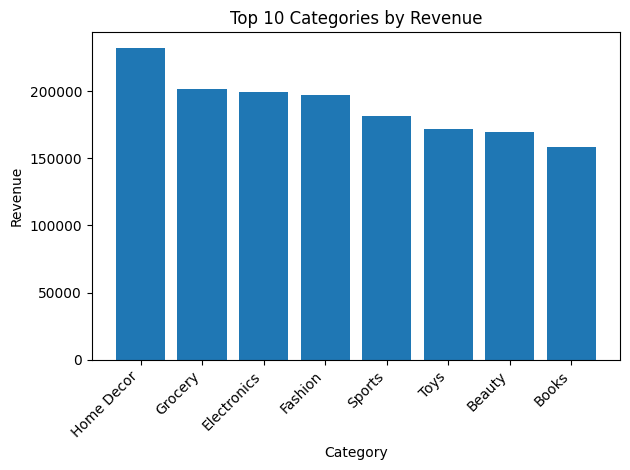

In [7]:
cat_rev = (
    df.groupby("Category", as_index = False)["Total_Amount"]
    .sum()
    .sort_values("Total_Amount", ascending = False)
)
plt.figure()
plt.bar(cat_rev["Category"], cat_rev["Total_Amount"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Categories by Revenue")
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show();

- Home Decor is the clear top revenue driver.
- Grocery, Electronics, and Fashion form a strong second tier.
- The company's revenue engine is category-driven, not evenly diversified across all product lines.

### 4) Unit Economics: Average Unit Price vs. Total Unit (By Category)

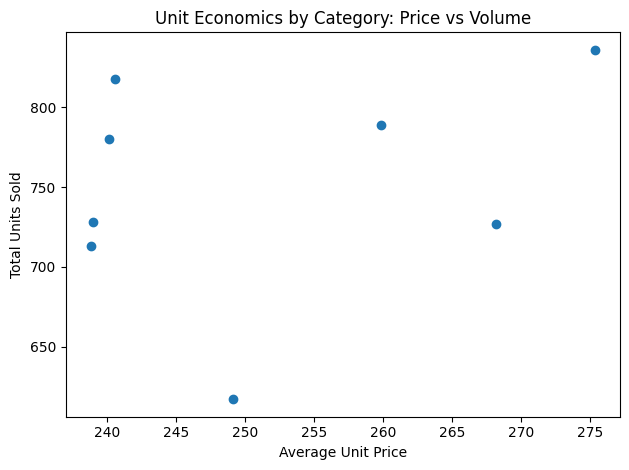

In [8]:
unit_sold = (
    df.groupby("Category", as_index=False)
      .agg(avg_unit_price=("Unit_Price", "mean"),
           total_units=("Quantity", "sum"),
           revenue=("Total_Amount", "sum"))
      .sort_values("revenue", ascending=False)
)

plt.figure()
plt.scatter(unit_sold["avg_unit_price"], unit_sold["total_units"])
plt.title("Unit Economics by Category: Price vs Volume")
plt.xlabel("Average Unit Price")
plt.ylabel("Total Units Sold")
plt.tight_layout()
plt.show()

- There is no strong inverse price-volume relationship, as which categories with higher average unit prices still achieve high unit sales.
- Demand is not highly price-base

### 5) January vs. July: Most Bought Categories (Units Sold)

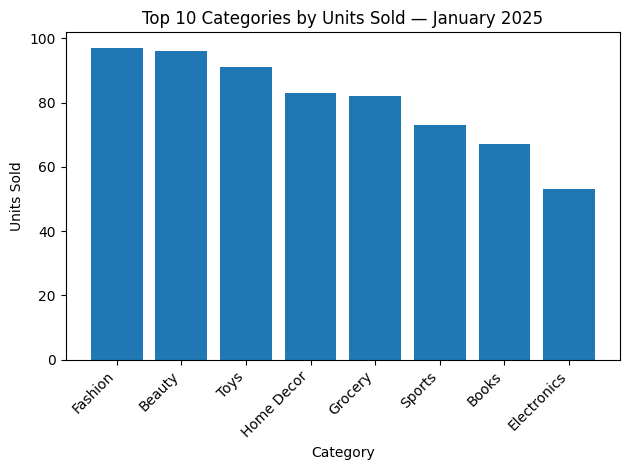

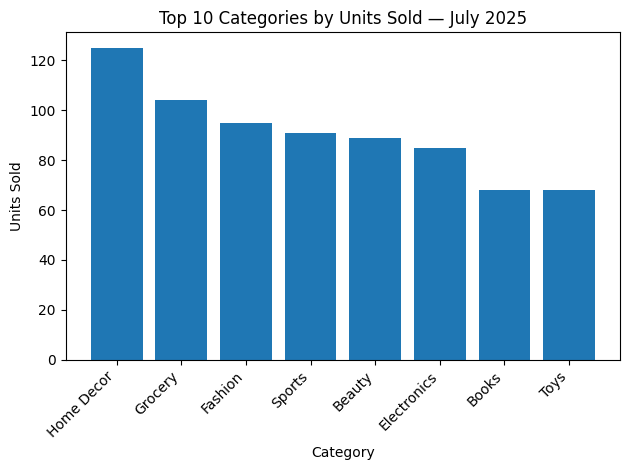

In [9]:
def top_categories_by_month(month_str, top_n=10):
    tmp = df[df["order_month"] == month_str]
    out = (tmp.groupby("Category", as_index=False)["Quantity"]
              .sum()
              .sort_values("Quantity", ascending=False)
              .head(top_n))
    return out

july_top = top_categories_by_month("2025-07", top_n=10)
jan_top  = top_categories_by_month("2025-01", top_n=10)

# Plot January
plt.figure()
plt.bar(jan_top["Category"], jan_top["Quantity"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Categories by Units Sold — January 2025")
plt.xlabel("Category")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show();

# Plot July
plt.figure()
plt.bar(july_top["Category"], july_top["Quantity"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Categories by Units Sold — July 2025")
plt.xlabel("Category")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show();


- January is dominated by lifestyle and personal consumption. Electronics ranks lowest among the top categories by unites, suggesting fewer big purchases early in the year.
- The demand in July shifts toward home-related purchases as home decor becomes the #1 category and grocery jumps to #2.

#### 6) USA vs. China vs. India: Top Categories by Revenue (Top 10)

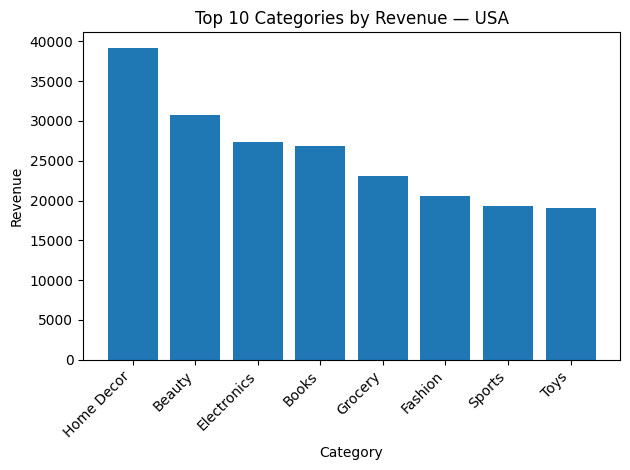

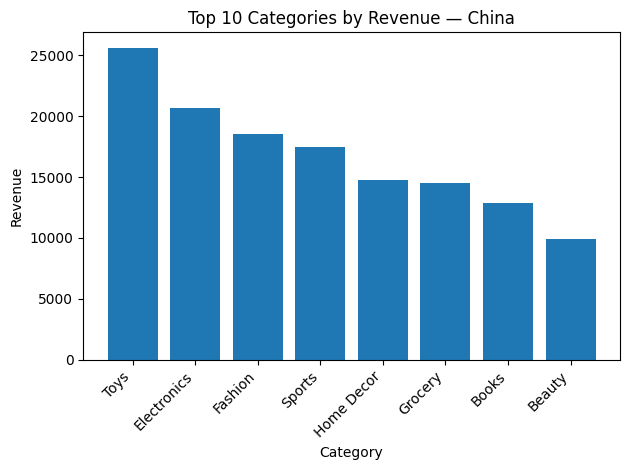

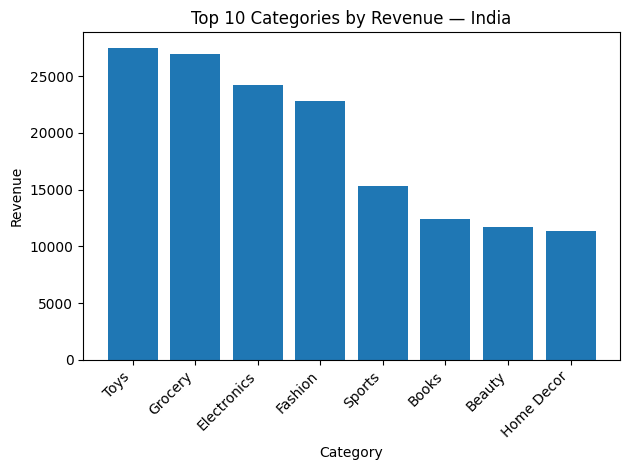

In [10]:
def top_categories_by_country(country_name, top_n=10):
    tmp = df[df["Country"] == country_name]
    out = (tmp.groupby("Category", as_index=False)["Total_Amount"]
              .sum()
              .sort_values("Total_Amount", ascending=False)
              .head(top_n))
    return out

for c in ["USA", "China", "India"]:
    topc = top_categories_by_country(c, top_n=10)
    plt.figure()
    plt.bar(topc["Category"], topc["Total_Amount"])
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Top 10 Categories by Revenue — {c}")
    plt.xlabel("Category")
    plt.ylabel("Revenue")
    plt.tight_layout()
    plt.show()

- The USA market strongly favors home improvement and lifestyle spending.
- China with strong performance of Toys and Electronics indicates a strong demand for consumer goods.
- India market is dominated with Toys and Grocery purchases, on the other hand, with Home Decor ranks lowest, ,implying more price-sensitive purchasing behavior.